# Notebook 3. KNN with TF-IDF
Author:
- Ivan Chernakov
- BS21-DS-02
- i.chernakov@innopolis.university

In [93]:
from utils import *
from sklearn.feature_extraction.text import TfidfVectorizer
from implicit.evaluation import csr_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt

In [2]:
rating_base, rating_test = load_movielens_ratings('u3.base'), load_movielens_ratings('u3.test')
print(f'Base shape: {rating_base.shape}, test shape: {rating_test.shape}')

Base shape: (80000, 4), test shape: (20000, 4)


In [15]:
movies = load_movielens_item_info()
display(movies.head())

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
# load genres
genres_path = os.path.join(DATASET_PATH_100K_MOVIELENS, "u.genre")
genres = pd.read_csv(genres_path, sep='|', header=None, names=['genre', 'id'])
genres_as_list = genres['genre'].tolist()

In [16]:
# unite columns on genres in lists respectively
movies['genres'] = movies.iloc[:, 5:].values.tolist()
movies['genres'] = movies['genres'].apply(lambda x: [genres_as_list[i] for i, v in enumerate(x) if v == 1])
movies.drop(movies.columns[5:24], axis=1, inplace=True)

display(movies.head())

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genres
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,[Thriller]
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[Crime, Drama, Thriller]"


In [22]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
tfidf_genres = tfidf.fit_transform(movies['genres'])

C:\Users\ivanc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
print(f'Genres vocabulary size:', tfidf_genres.shape)

Genres vocabulary size: (1682, 19)


In [147]:
class KNNRecommender:
    """
    Recommender based on KNN
    """
    def __init__(self, n_neighbors=10):
        self.n_neighbors = n_neighbors
        self.model = NearestNeighbors(metric='cosine', n_neighbors=n_neighbors)
        
    def fit(self, X):
        self.model.fit(X)

    def _predict(self, tfidf, user_index):
        """
        Predicts movies for user
        :param tfidf: TF-IDF matrix
        :param query_index: user index
        :return: list of movie ids
        """
        self.fit(csr_matrix(tfidf))

        distances, idx = self.model.kneighbors(tfidf[user_index,:].reshape(1, -1))
    
        results = []
        for i in range(0, len(distances.flatten())):
            tmp_idx = idx.flatten()[i]
            results.append(tmp_idx)
    
        return results

    def evaluate(self, rating_test, tfidf):
        """
        Evaluates recommender
        :param rating_test: Test dataset
        :param tfidf: TF-IDF matrix
        :return: hit rate and RMSE
        """
        hits = 0
        watched_movies_list = []
        predicted_movies_list = []
        
        # get predictions
        for user_id in rating_test['user_id'].unique():
            # get all movies that user watched
            watched_movies = rating_test[rating_test['user_id'] == user_id]['item_id'].tolist()
            watched_movies_list.append(watched_movies)
            
            predicted_movies = self._predict(tfidf, user_id)
            predicted_movies_list.append(predicted_movies)
    
        # calculate hit rate
        for i in range(len(watched_movies_list)):
            watched_movies = watched_movies_list[i]
            predicted_movies = predicted_movies_list[i]
    
            # check if any of predicted movies is in watched
            for movie_id in predicted_movies:
                if movie_id in watched_movies:
                    hits += 1
                    break
    
        hits = hits / rating_test['user_id'].nunique()
    
        # calculate MSE
        mse = 0
        for i in range(len(watched_movies_list)):
            watched_movies = watched_movies_list[i]
            predicted_movies = predicted_movies_list[i]
    
            # check if any of predicted movies is in watched
            for movie_id in predicted_movies:
                if movie_id in watched_movies:
                    mse += (1 - predicted_movies.index(movie_id) / self.n_neighbors) ** 2
                    break
    
        mse = mse / rating_test['user_id'].nunique()
        rmse = np.sqrt(mse)
    
        return hits, rmse

In [148]:
knn = KNNRecommender(n_neighbors=50)
hits, rmse = knn.evaluate(rating_test, tfidf_genres)
print(f'Hit rate: {hits}, RMSE: {rmse}')

Hit rate: 0.3861920172599784, RMSE: 0.41945153483508985


In [155]:
evaluaiton_results = []

tests = ['u1.test', 'u2.test', 'u3.test', 'u4.test', 'u5.test']

for test in tests:
    rating_test = load_movielens_ratings(test)
    hits, rmse = knn.evaluate(rating_test, tfidf_genres)
    evaluaiton_results.append((hits, rmse))
    print(test)
    print(f'Hit rate: {hits}, RMSE: {rmse}')

u1.test
Hit rate: 0.5925925925925926, RMSE: 0.549783875143853
u2.test
Hit rate: 0.5007656967840735, RMSE: 0.4760216706560218
u3.test
Hit rate: 0.4004602991944764, RMSE: 0.41551720235694867
u4.test
Hit rate: 0.38136511375947996, RMSE: 0.41797219811433983
u5.test
Hit rate: 0.3861920172599784, RMSE: 0.41945153483508985


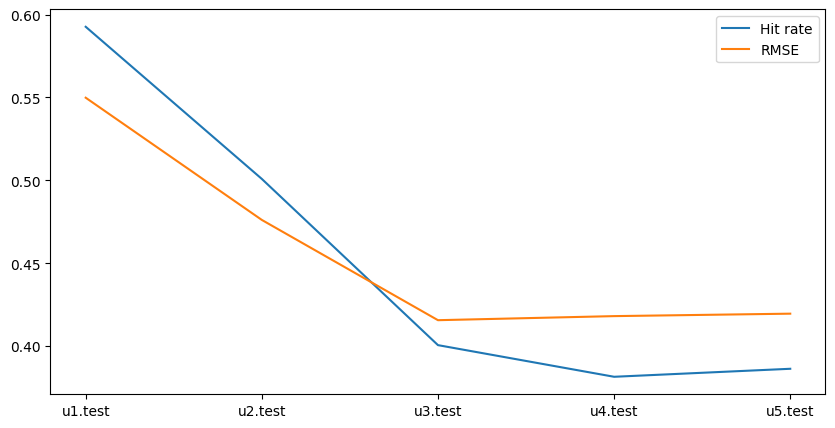

In [151]:
# plot results
hits = [x[0] for x in evaluaiton_results]
mse = [x[1] for x in evaluaiton_results]

plt.figure(figsize=(10, 5))
plt.plot(tests, hits, label='Hit rate')
plt.plot(tests, mse, label='RMSE')
plt.legend()
plt.show()